# Gridworld

Create the environment from the Russell and Norvig’s book on AI: **the Gridworld**. This environment is a 3 x 4 grid world in which the agent starts at the bottom-left corner, and it has to reach the top-right corner. There is a hole south of the goal and a wall near the start. The transition function has a 20% noise; that is, 80% the action succeeds, and 20% it fails uniformly at random in orthogonal directions. The reward function is a –0.04 living penalty, a +1 for landing on the goal, and a –1 for landing on the hole.

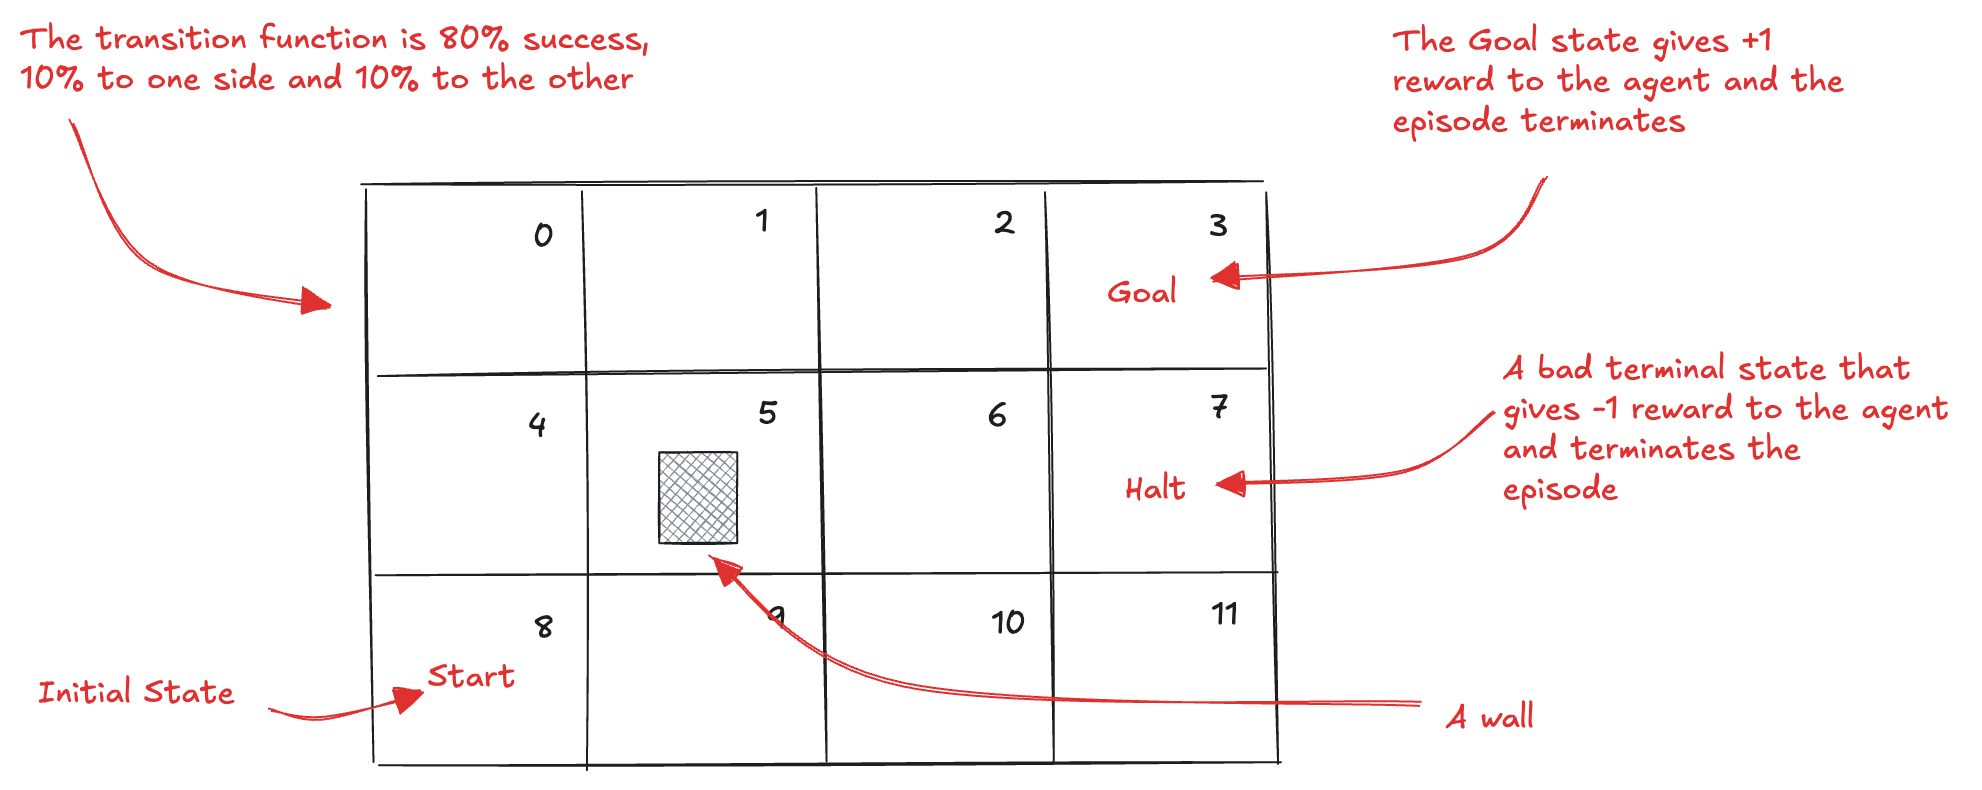


1 - Create the environment Gridworld as described above.

In [9]:
# YOUR CODE HERE

# The environment should be a class with the following methods: 
# `__init__(self)`: initialize the environment
# `reset(self)`: reset the environment to the initial state
# `step(self, action)`: take an action in the environment. 
# The action should be an integer between 0 and 3, where 0 means left, 
# 1 means down, 2 means right, and 3 means up. 
# The method should return a tuple (state, reward, done), 
# where state is the new state, reward is the reward obtained, and done is 
# a boolean indicating whether the episode is finished.

UP, DOWN, LEFT, RIGHT = range(4)

class GridWorld:
    
    # 0:UP, 1:DOWN, 2:LEFT 3:RIGHT
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 12
        self.state = 8
        self.columns = 4
        self.rows = 3
        self.terminated = False
        self.reward = 0
        return self.state
    
    def step(self, action):
        if self.terminated: raise ValueError('Episode has terminated')
        if action not in [UP, DOWN, LEFT, RIGHT]: raise ValueError('Invalid action')
        
        # add stochasticity
        if action == UP: action = np.random.choice([UP, LEFT, RIGHT], p=[0.8, 0.1, 0.1])
        if action == DOWN: action = np.random.choice([DOWN, LEFT, RIGHT], p=[0.8, 0.1, 0.1])
        if action == LEFT: action = np.random.choice([LEFT, UP, DOWN], p=[0.8, 0.1, 0.1])
        if action == RIGHT: action = np.random.choice([RIGHT, UP, DOWN], p=[0.8, 0.1, 0.1])

        # manage boundaries        
        row    = self.state // self.columns
        column = self.state % self.columns
        if action == LEFT: column = max(column - 1, 0)
        if action == DOWN: row = min(row + 1, self.rows - 1)
        if action == RIGHT: column = min(column + 1, self.columns - 1)
        if action == UP: row = max(row - 1, 0)
        
        # manage obstacles
        old_state = self.state      
        self.state = row * self.columns + column
        if self.state == 5: self.state = old_state

        # manage rewards        
        self.reward = -0.04
        if self.state == 3: self.terminated = True; self.reward = 1
        elif self.state == 7: self.terminated = True; self.reward = -1   
        
        return self.state, self.reward, self.terminated, 0, 0

grid_world = GridWorld()

2 - Write the following policy for this environment

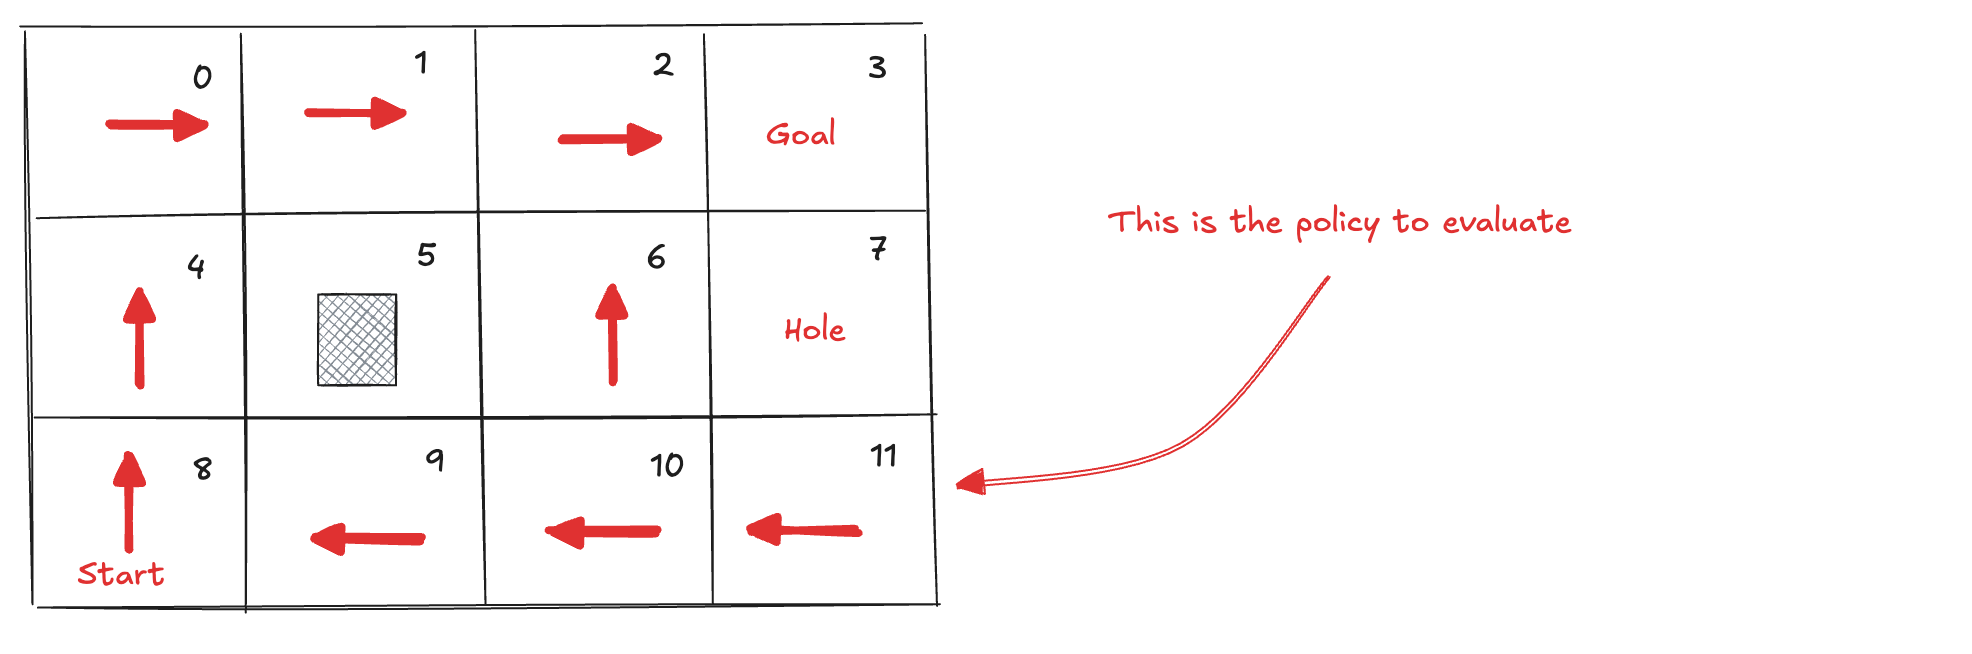

In [ ]:
# YOUR CODE HERE

# The policy should be a function that takes an integer between 0 and 11
# (the state) and returns an integer between 0 and 3 (the action).

pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]

3 - Show the policy by printing the selected action for each state:

In [3]:
# YOUR CODE HERE

# The function should print the policy in a human-readable format.
# For example, the output could be:
# state: 0 -> action: RIGHT
# state: 1 -> action: RIGHT
# etc...

def print_policy(pi, env):
    for state in range(env.observation_space):
        action = pi(state)
        action_icon = ' '
        if action == UP: action_icon = 'UP'
        if action == DOWN: action_icon = 'DOWN'
        if action == LEFT: action_icon = 'LEFT'
        if action == RIGHT: action_icon = 'RIGHT'
        print('state:', state, '->', 'action:', action_icon)

print_policy(pi, grid_world)

state: 0 -> action: RIGHT
state: 1 -> action: RIGHT
state: 2 -> action: RIGHT
state: 3 -> action: LEFT
state: 4 -> action: UP
state: 5 -> action: LEFT
state: 6 -> action: UP
state: 7 -> action: LEFT
state: 8 -> action: UP
state: 9 -> action: LEFT
state: 10 -> action: LEFT
state: 11 -> action: LEFT


4 - Now, evaluate this policy using TD($\lambda$)

In [4]:
# YOUR CODE HERE

# you need to decay alpha

import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps
    
    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

In [5]:
# YOUR CODE HERE

# you need to decay the discount

def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

In [7]:
# YOUR CODE HERE

# you need the td_lambda implementation

def td_lambda(pi, env, gamma=1.0, lambda_=0.2, 
              init_alpha=0.5, min_alpha=0.01, 
              decay_episodes=350, n_episodes=500):

    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);

    # initialize the current estimate of the state-value function
    v = np.zeros(env.observation_space, dtype=float)

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float)
    
    # initialize the eligibility trace vector
    E = np.zeros(env.observation_space, dtype=float)
    
    # loop for every episode
    for e in range(n_episodes):
        
        # set E to zero every new episode
        E.fill(0)
        
        # get the initial state
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # interact with the environment for one step and get the experience tuple
            next_state, reward, terminated, truncated, info = env.step(action)
            if(terminated or truncated):
                done = True;
            
            # use that experience to calculate the TD error as usual
            td_target = reward + gamma * v[next_state] * (not done)
            td_error = td_target - v[state]
            
            # increment the eligibility of state by 1
            E[state] = E[state] + 1
            
            # apply the error update to all eligible states as indicated by E
            v = v + alphas[e] * td_error * E
            
            # decay E
            E =  lambda_ * E
            
            # update the state variable for the next iteration
            state = next_state
            
        v_track[e] = v

    return v, v_track

In [10]:
# YOUR CODE HERE

# run the algorithm and print the value function

v_td_lambda, v_td_lambda_track = td_lambda(pi, grid_world, lambda_=0.3, n_episodes=500)
print(v_td_lambda)

[0.8415656  0.89934748 0.95800912 0.         0.79107068 0.
 0.61815666 0.         0.74072074 0.60860885 0.         0.        ]


5 - Plot the estimated value for state 8, 6 and 2 for all episodes

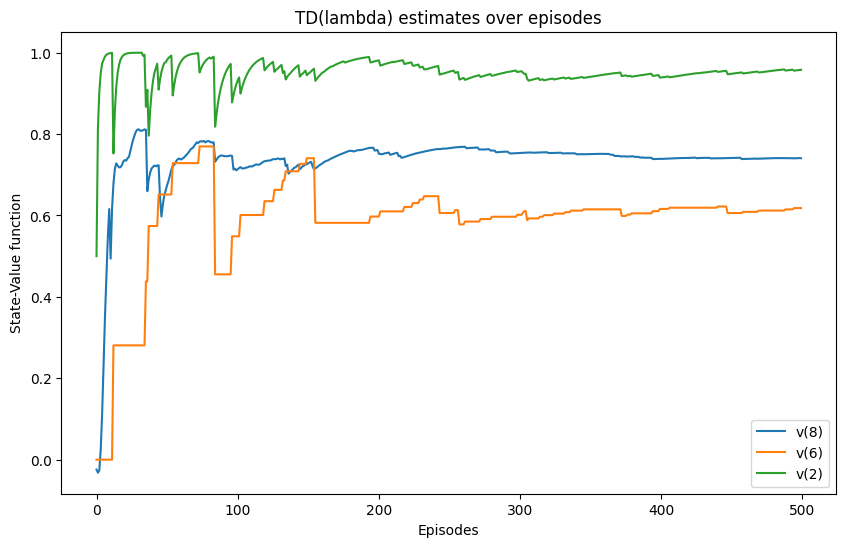

In [15]:
# YOUR CODE HERE

# plot the value function over episodes for state 8, 6 and 2

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
legends = ['v(8)','v(6)','v(2)']
plt.plot(v_td_lambda_track[:,8])
plt.plot(v_td_lambda_track[:,6])
plt.plot(v_td_lambda_track[:,2])
plt.title('TD(lambda) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()